# Brain Tumor Detection: EfficientNet, ResNet, XCeption
Source: https://www.kaggle.com/code/anitarostami/brain-tumor-detection-efficientnet-resnet-xception/notebook

In [1]:
%pip install -r requirements2.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from warnings import filterwarnings

# Print Dataset
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-04-14 19:40:38.621151: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 19:40:38.626948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744674038.634371   10074 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744674038.636868   10074 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 19:40:38.644517: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

dataset/brain.tar.gz
dataset/Testing/glioma/Te-glTr_0000.jpg
dataset/Testing/glioma/Te-glTr_0001.jpg
dataset/Testing/glioma/Te-glTr_0002.jpg
dataset/Testing/glioma/Te-glTr_0003.jpg
dataset/Testing/glioma/Te-glTr_0004.jpg
dataset/Testing/glioma/Te-glTr_0005.jpg
dataset/Testing/glioma/Te-glTr_0006.jpg
dataset/Testing/glioma/Te-glTr_0007.jpg
dataset/Testing/glioma/Te-glTr_0008.jpg
dataset/Testing/glioma/Te-glTr_0009.jpg
dataset/Testing/glioma/Te-gl_0010.jpg
dataset/Testing/glioma/Te-gl_0011.jpg
dataset/Testing/glioma/Te-gl_0012.jpg
dataset/Testing/glioma/Te-gl_0013.jpg
dataset/Testing/glioma/Te-gl_0014.jpg
dataset/Testing/glioma/Te-gl_0015.jpg
dataset/Testing/glioma/Te-gl_0016.jpg
dataset/Testing/glioma/Te-gl_0018.jpg
dataset/Testing/glioma/Te-gl_0019.jpg
dataset/Testing/glioma/Te-gl_0020.jpg
dataset/Testing/glioma/Te-gl_0021.jpg
dataset/Testing/glioma/Te-gl_0022.jpg
dataset/Testing/glioma/Te-gl_0023.jpg
dataset/Testing/glioma/Te-gl_0024.jpg
dataset/Testing/glioma/Te-gl_0025.jpg
dataset/T

### Data Preparation

In [2]:
X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']


image_size = 150
for i in labels:
    folderPath = os.path.join('dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:00<00:00, 2246.97it/s]


### Data Visualization

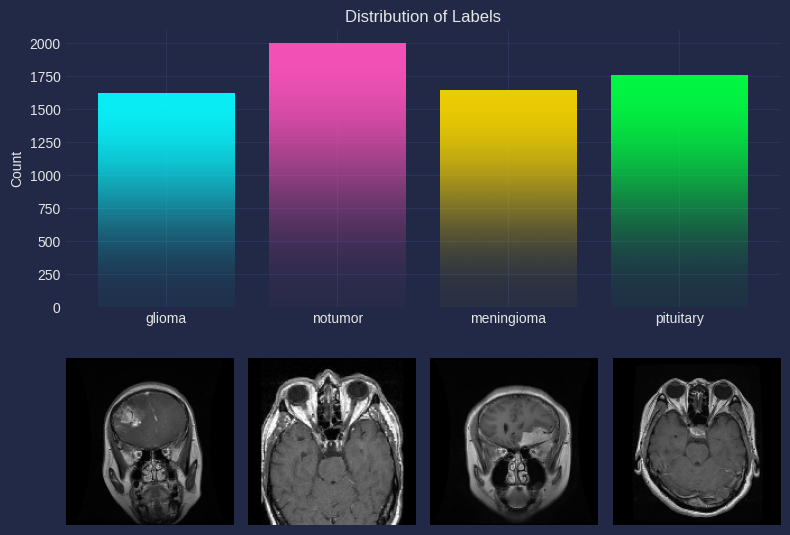

In [3]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

### Dataset Split and Train

In [4]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

### One Hot Encoding Labels

In [5]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

### EfficientNet

In [30]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 5,323,392 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [31]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [32]:
history = model.fit(X_train,y_train,validation_split = 0.1, epochs = 12, verbose = 1,
                    batch_size = 32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8195 - loss: 0.4724
Epoch 1: val_accuracy improved from -inf to 0.88608, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.8199 - loss: 0.4715 - val_accuracy: 0.8861 - val_loss: 0.3490 - learning_rate: 0.0010
Epoch 2/12
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9583 - loss: 0.1271
Epoch 2: val_accuracy improved from 0.88608 to 0.91456, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9583 - loss: 0.1270 - val_accuracy: 0.9146 - val_loss: 0.2577 - learning_rate: 0.0010
Epoch 3/12
176/178 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9578 - loss: 0.1375
Epoch 3: val_accuracy did not improve from 0.91456
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9579 - loss: 0.1372 - val_accuracy: 0.8782 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 4/12
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9714 - los

In [11]:
model.save('checkpoints/efficientnet_checkpoint.keras')

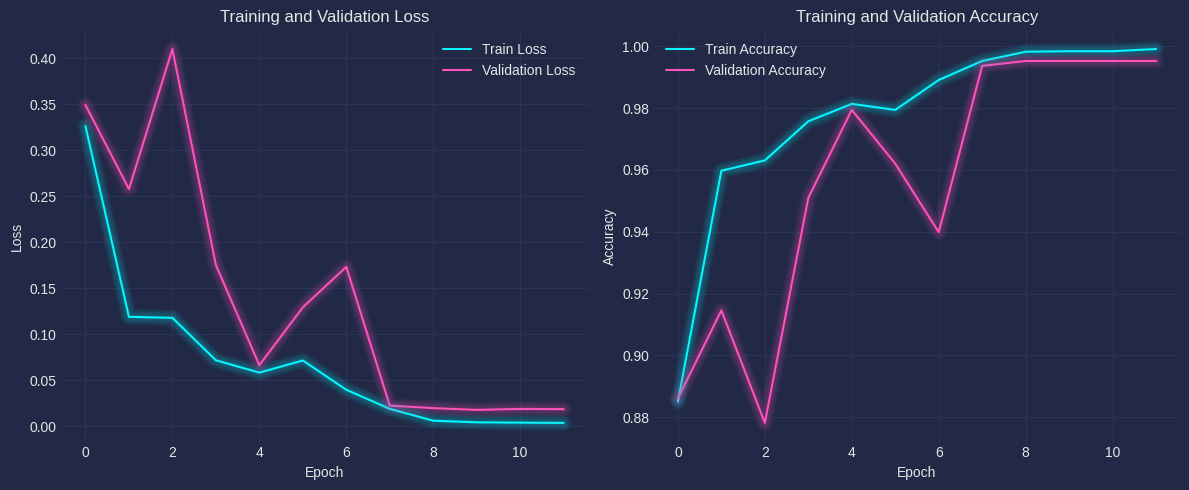

In [33]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()


### Evaluation

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:
[[168   0   2   0]
 [  0 203   0   0]
 [  1   0 171   2]
 [  0   1   2 153]]


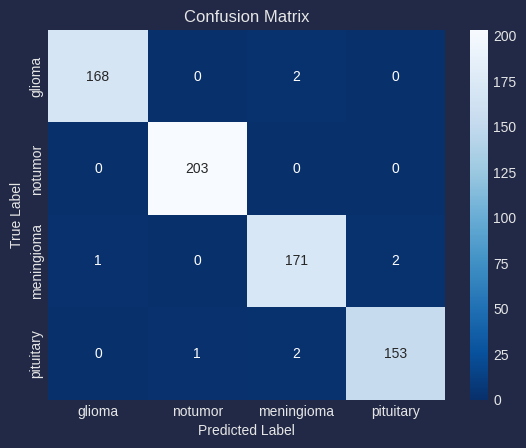

In [35]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       170
           1       1.00      1.00      1.00       203
           2       0.97      0.98      0.97       174
           3       0.99      0.99      0.99       156

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



### Prediction

E0000 00:00:1744674890.774524   10304 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744674890.881891   10304 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744674890.988326   10304 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744674891.095858   10304 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744674891.202192   10304 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: meningioma 
Actual label: meningioma 
Confidence: 100.00%



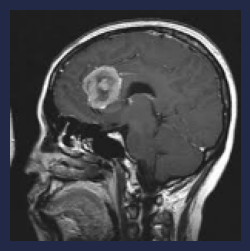

In [17]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

In [18]:
!nvidia-smi

Mon Apr 14 19:54:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0  On |                  N/A |
| 30%   36C    P2            117W /  350W |   23923MiB /  24576MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()


## ResNet101

In [20]:

# Load the ResNet101 model pretrained on ImageNet without the top layers
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

# Build the custom model on top of the ResNet101 base

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 42,666,372 (162.76 MB)

 Trainable params: 42,561,028 (162.36 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [21]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [22]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15


E0000 00:00:1744674958.418191   10301 buffer_comparator.cc:157] Difference at 64: 0.000773598, expected 2.20132
E0000 00:00:1744674958.418216   10301 buffer_comparator.cc:157] Difference at 65: 0.0237599, expected 2.06797
E0000 00:00:1744674958.418221   10301 buffer_comparator.cc:157] Difference at 66: 0.0133533, expected 1.64481
E0000 00:00:1744674958.418223   10301 buffer_comparator.cc:157] Difference at 67: 0.0219748, expected 2.01379
E0000 00:00:1744674958.418224   10301 buffer_comparator.cc:157] Difference at 68: -0.00375374, expected 1.78577
E0000 00:00:1744674958.418226   10301 buffer_comparator.cc:157] Difference at 69: -0.0325838, expected 1.67553
E0000 00:00:1744674958.418227   10301 buffer_comparator.cc:157] Difference at 70: 0.0048274, expected 1.77877
E0000 00:00:1744674958.418229   10301 buffer_comparator.cc:157] Difference at 71: 0.00841821, expected 2.00766
E0000 00:00:1744674958.418230   10301 buffer_comparator.cc:157] Difference at 72: 0.0291337, expected 2.70426
E000

177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7021 - loss: 0.9414

E0000 00:00:1744674988.528173   10301 buffer_comparator.cc:157] Difference at 64: 0, expected 2.23785
E0000 00:00:1744674988.528193   10301 buffer_comparator.cc:157] Difference at 65: 0, expected 1.55976
E0000 00:00:1744674988.528195   10301 buffer_comparator.cc:157] Difference at 66: 0, expected 1.60761
E0000 00:00:1744674988.528196   10301 buffer_comparator.cc:157] Difference at 67: 0, expected 1.53937
E0000 00:00:1744674988.528197   10301 buffer_comparator.cc:157] Difference at 68: 0, expected 1.9815
E0000 00:00:1744674988.528198   10301 buffer_comparator.cc:157] Difference at 69: 0, expected 1.49197
E0000 00:00:1744674988.528199   10301 buffer_comparator.cc:157] Difference at 70: 0, expected 1.40088
E0000 00:00:1744674988.528200   10301 buffer_comparator.cc:157] Difference at 71: 0, expected 1.16058
E0000 00:00:1744674988.528201   10301 buffer_comparator.cc:157] Difference at 72: 0, expected 6.04391
E0000 00:00:1744674988.528202   10301 buffer_comparator.cc:157] Difference at 73: 0

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7025 - loss: 0.9402

2025-04-14 19:56:39.094848: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3321', 192 bytes spill stores, 192 bytes spill loads

E0000 00:00:1744674999.104063   10301 buffer_comparator.cc:157] Difference at 36: 18.0921, expected 20.4329
E0000 00:00:1744674999.104082   10301 buffer_comparator.cc:157] Difference at 64: 26.5485, expected 21.0351
E0000 00:00:1744674999.104083   10301 buffer_comparator.cc:157] Difference at 65: 18.601, expected 21.023
E0000 00:00:1744674999.104085   10301 buffer_comparator.cc:157] Difference at 68: 30.6119, expected 21.1176
E0000 00:00:1744674999.104086   10301 buffer_comparator.cc:157] Difference at 72: 31.4184, expected 20.5265
E0000 00:00:1744674999.104087   10301 buffer_comparator.cc:157] Difference at 74: 23.8023, expected 20.3628
E0000 00:00:1744674999.104088   10301 buffer_comparator.cc:157] Difference at 75: 23.1346, expected 19.9434
E0000 00:


Epoch 1: val_accuracy improved from -inf to 0.26741, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 202ms/step - accuracy: 0.7029 - loss: 0.9389 - val_accuracy: 0.2674 - val_loss: 219.4594 - learning_rate: 0.0010
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8695 - loss: 0.3508
Epoch 2: val_accuracy improved from 0.26741 to 0.53165, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.8695 - loss: 0.3506 - val_accuracy: 0.5316 - val_loss: 3.9699 - learning_rate: 0.0010
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9005 - loss: 0.2788
Epoch 3: val_accuracy improved from 0.53165 to 0.88133, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.9005 - loss: 0.2787 - val_accuracy: 0.8813 - val_loss: 0.3360 - learning_rate: 0.0010
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9460 - loss: 0.1568
Epoch 4: val_accuracy did no

In [28]:
model.save('checkpoints/resnet101_checkpoint.keras')

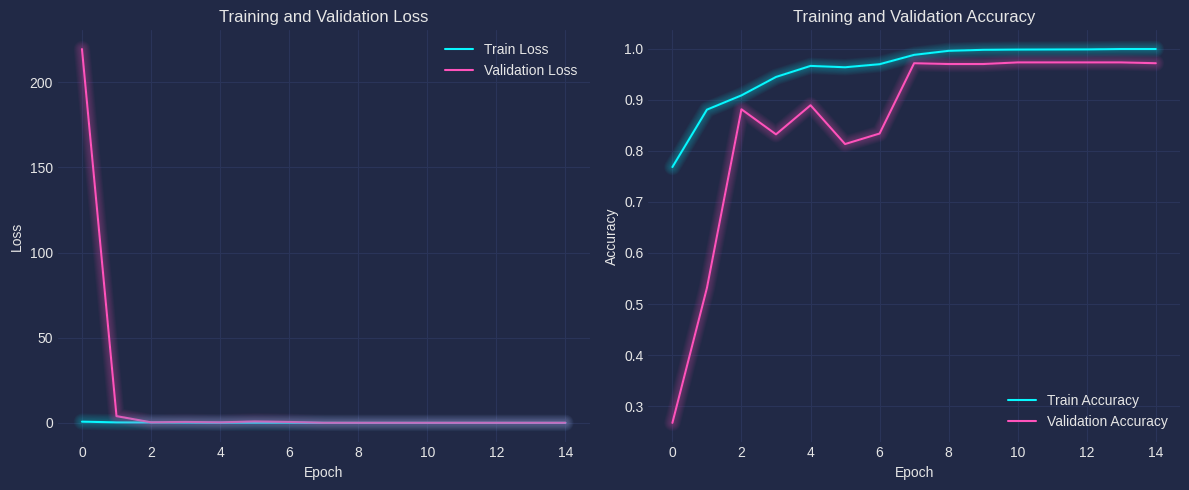

In [23]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Confusion Matrix:
[[163   0   7   0]
 [  0 202   1   0]
 [  2   0 169   3]
 [  0   0   3 153]]


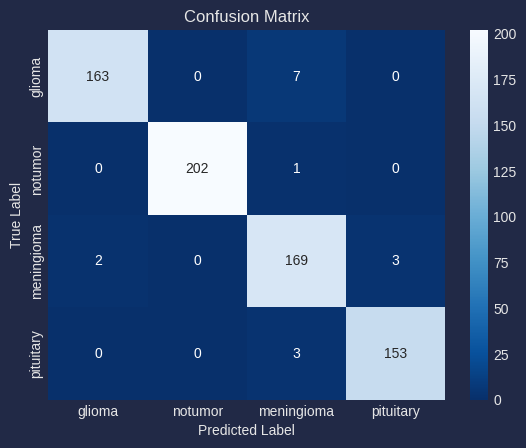

In [25]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 
conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)


heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [26]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       170
           1       1.00      1.00      1.00       203
           2       0.94      0.97      0.95       174
           3       0.98      0.98      0.98       156

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



## Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: pituitary 
Actual label: pituitary 
Confidence: 87.49%



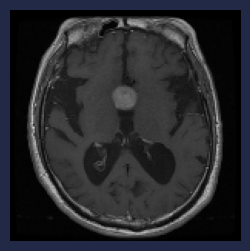

In [27]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

## XCeption

In [36]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()

In [37]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 36, 36,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add[0][0]       

 Total params: 24,014,892 (91.61 MB)

 Trainable params: 23,960,364 (91.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [40]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/xception_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [41]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9885 - loss: 0.0362
Epoch 1: val_accuracy improved from -inf to 0.97310, saving model to checkpoints/xception_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9885 - loss: 0.0362 - val_accuracy: 0.9731 - val_loss: 0.0737 - learning_rate: 1.0000e-04
Epoch 2/12
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9955 - loss: 0.0153
Epoch 2: val_accuracy improved from 0.97310 to 0.97785, saving model to checkpoints/xception_checkpoint.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9955 - loss: 0.0153 - val_accuracy: 0.9778 - val_loss: 0.0629 - learning_rate: 1.0000e-04
Epoch 3/12
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9978 - loss: 0.0078
Epoch 3: val_accuracy did not improve from 0.97785
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9978 - loss: 0.0078 - val_accuracy: 0.9763 - val_loss: 0.0652 - learning_rate: 1.0000e-04
Epoch 4/12
177/178 ━━━━━━━━━━━

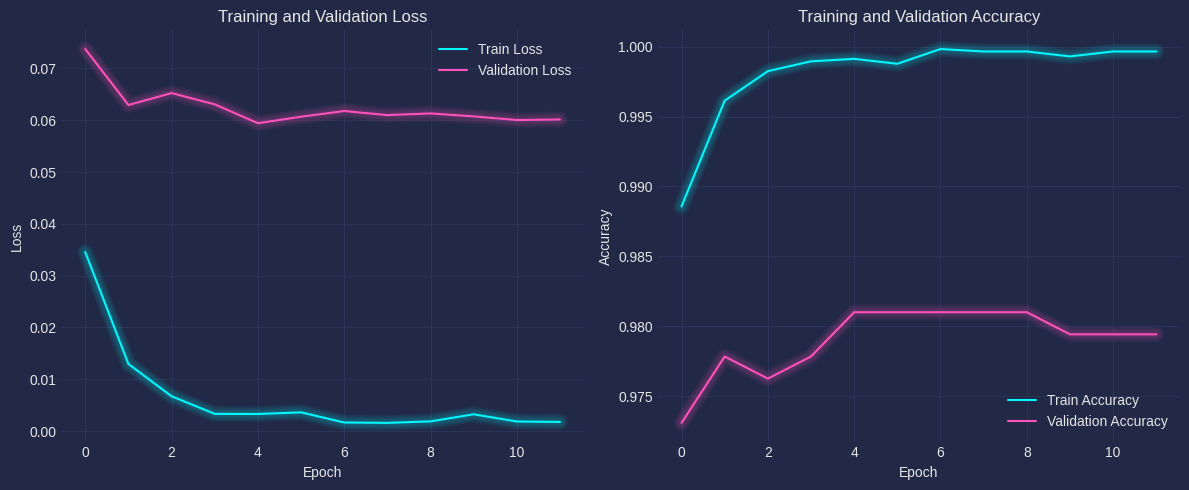

In [42]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2025-04-14 20:14:19.035146: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1021', 4 bytes spill stores, 4 bytes spill loads

2025-04-14 20:14:19.107582: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1021', 188 bytes spill stores, 188 bytes spill loads

2025-04-14 20:14:19.132492: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014_0', 108 bytes spill stores, 296 bytes spill loads

2025-04-14 20:14:19.236734: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014', 176 bytes spill stores, 436 bytes spill loads

E0000 00:00:1744676059.238655   10302 buffer_comparato

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step


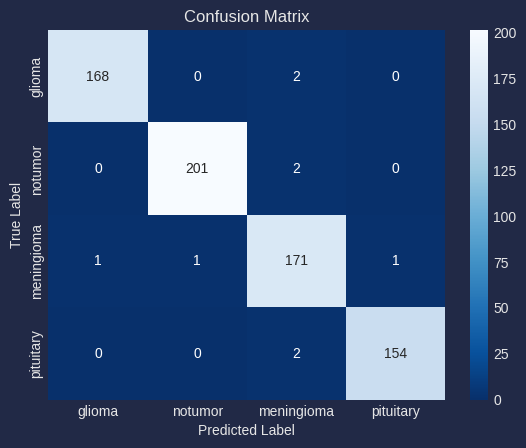

In [43]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       170
           1       1.00      0.99      0.99       203
           2       0.97      0.98      0.97       174
           3       0.99      0.99      0.99       156

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



### Prediction

E0000 00:00:1744676071.252834   10302 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744676071.357230   10302 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744676071.526932   10302 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744676071.630836   10302 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744676071.834172   10302 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: notumor 
Actual label: notumor 
Confidence: 99.99%



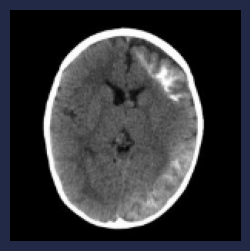

In [45]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class] 

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

In [46]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()